In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

In [80]:
df = pd.read_csv('lab2.csv', sep=',')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [81]:
df = df.drop(['name'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non-null    int64  
 1

Скалирование данных

In [82]:
X = df.drop(['status'], axis=1) 
y = df['status']

In [83]:
scalar = StandardScaler()
X = scalar.fit_transform(X)
print(X)

[[-0.82929965 -0.43616456 -0.95203729 ...  0.48047686 -0.21053082
   0.86888575]
 [-0.77097169 -0.53097409 -0.05772056 ...  1.31118546  0.27507712
   1.80360503]
 [-0.90947638 -0.7231683  -0.10987483 ...  1.01768236 -0.10362861
   1.40266141]
 ...
 [ 0.49557839  0.47010361 -0.96839309 ... -0.81807931  0.78033848
  -0.83241014]
 [ 1.07876114  2.19004398 -0.95417967 ... -0.22906571 -0.63700298
  -0.92610456]
 [ 1.45481664  0.69224632 -0.88348115 ... -0.43085284  0.45480231
  -0.64505466]]


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Вычисляем веса классов

In [85]:
class_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y= y_train)

## XGBoost

In [127]:
model_xgb = XGBClassifier(booster='gbtree', n_estimators = 450, learning_rate = 0.7, random_state = 270)
model_xgb.fit(X_train, y_train, sample_weight=class_weights)
y_pred = model_xgb.predict(X_test)

ac = accuracy_score(y_test, y_pred)
print('Accuracy:', ac)

Accuracy: 0.9591836734693877


# Матрица ошибок

In [110]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[ 9  2]
 [ 0 38]]


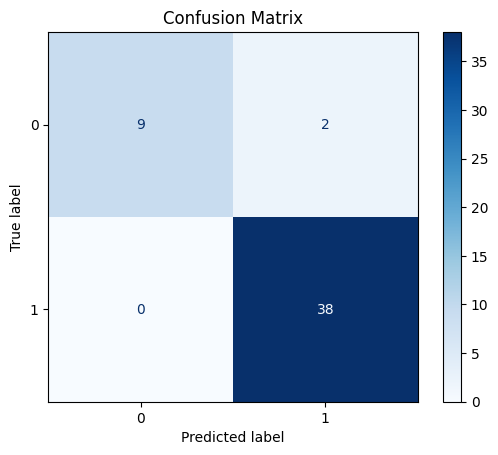

In [126]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
disp.plot(cmap=plt.cm.Blues)  # Можно изменить цветовую карту
plt.title('Confusion Matrix')  # Добавляем заголовок
plt.show()

# ROC-curve

In [111]:
y_proba = model_xgb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

roc_auc = roc_auc_score(y_test, y_proba)
print('ROC AUC:', roc_auc)


ROC AUC: 0.9665071770334928


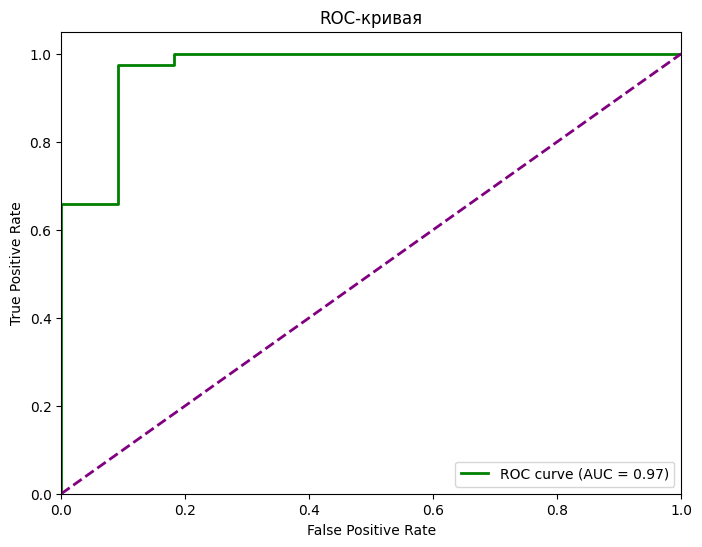

In [122]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')  # Случайная линия
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

# RandomForest

In [88]:
model_rf = RandomForestClassifier( )
model_rf.fit(X_train, y_train, sample_weight=class_weights)

ac = accuracy_score(y_test, y_pred)
print('Accuracy:', ac)



Accuracy: 0.9387755102040817
